In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

DATA_PATH = './data'
SELECT_YEAR = 2017

### Data Read

In [2]:

data_file = '{}/{}/preprocess.csv.xz'.format(DATA_PATH, SELECT_YEAR)
df = pd.read_csv(data_file, header=None, compression='xz')
print('{} docs shape'.format(df.shape))

(3055, 1) docs shape


### TF-IDF

In [3]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=.0025, max_df=.1, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df[0])

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



,term,weight
849,learn,0.016811
1445,softwar,0.015187
1199,problem,0.014865
947,method,0.014180
425,detect,0.013513
541,evalu,0.013385
1202,process,0.012900
431,develop,0.012835
296,comput,0.012755
1083,optim,0.012375


In [4]:
print('vocabulary: {}'.format(len(tfidf_vectorizer.vocabulary_)))
print('sparse matrix shape: {}'.format(tfidf.shape))
print('nonzero count: {}'.format(tfidf.nnz))
print('sparsity: {:.3f}'.format(100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

vocabulary: 1734
sparse matrix shape: (3055, 1734)
nonzero count: 48443
sparsity: 0.914


## NMF

In [5]:
nmf = NMF(n_components=50, solver="mu")
W = nmf.fit_transform(tfidf)
H = nmf.components_

idx_to_word = np.array(tfidf_vectorizer.get_feature_names())
for i, topic in enumerate(H):
    print('Topic {}: {}'.format(i + 1, ','.join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: lung,spectral,imag use,imag base,forest,classifi,recognit,automat,segment,imag
Topic 2: ecosystem,softwar develop,case,softwar engin,engin,softwar product,line,product line,product,softwar
Topic 3: locat,neighborhood,search,schedul problem,solv,rout problem,heurist,schedul,rout,problem
Topic 4: interfac,mobil robot,chao,switch,format,robot,voltag,autonom,robust,control
Topic 5: deep learn,learn approach,base learn,educ,environ,learn object,machin learn,learn environ,machin,learn
Topic 6: larg,number,databas,threshold,convex,path,modal,color,edg,graph
Topic 7: rout,power,network use,channel,industri,sink,sensor network,wireless sensor,wireless,sensor
Topic 8: big,privaci,secur,environ,evalu,perform,cloud comput,servic,comput,cloud
Topic 9: simul,gpu base,gpu,schedul,forecast,time seri,seri,real time,real,time
Topic 10: map studi,requir,systemat review,systemat map,systemat literatur,map,literatur review,literatur,review,systemat
Topic 11: learn environ,3d,virtual learn,immers,t

In [6]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names()
display_topics(nmf,idx_to_word,no_top_words)


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 45 words,Topic 45 weights,Topic 46 words,Topic 46 weights,Topic 47 words,Topic 47 weights,Topic 48 words,Topic 48 weights,Topic 49 words,Topic 49 weights
0,imag,2.642,softwar,2.250,problem,2.423,control,2.509,learn,2.567,...,ontolog,2.111,complex,1.546,chang,1.794,realiti,1.101,select,1.933
1,segment,0.999,product,0.897,rout,0.438,robust,0.244,machin,0.423,...,languag,0.609,low,1.024,estim,0.809,augment,1.003,featur select,1.109
2,automat,0.546,product line,0.834,schedul,0.420,autonom,0.229,learn environ,0.406,...,portugues,0.448,cost,0.553,water,0.755,augment realiti,0.912,featur,1.090
3,recognit,0.381,line,0.817,heurist,0.401,voltag,0.219,machin learn,0.389,...,pattern,0.407,hevc,0.549,soil,0.612,vehicl,0.884,dynam,0.390
4,classifi,0.329,softwar product,0.727,rout problem,0.391,robot,0.179,learn object,0.375,...,conceptu,0.404,low cost,0.494,like,0.400,unman,0.655,classifi,0.369
5,forest,0.309,engin,0.525,solv,0.387,format,0.166,environ,0.309,...,entiti,0.394,logic,0.474,measur,0.368,aerial,0.587,variabl,0.304
6,imag base,0.295,softwar engin,0.371,schedul problem,0.341,switch,0.157,educ,0.267,...,semant,0.342,3d,0.469,basin,0.358,aerial vehicl,0.568,individu,0.300
7,imag use,0.292,case,0.343,search,0.335,chao,0.156,base learn,0.265,...,domain,0.335,complex network,0.413,climat,0.334,unman aerial,0.565,gpu,0.292
8,spectral,0.268,softwar develop,0.322,neighborhood,0.295,mobil robot,0.148,learn approach,0.257,...,align,0.324,video,0.396,region,0.327,track,0.487,diagnosi,0.278
9,lung,0.256,ecosystem,0.304,locat,0.266,interfac,0.148,deep learn,0.250,...,conceptu model,0.309,assess,0.365,field,0.307,strategi,0.457,ensembl,0.273


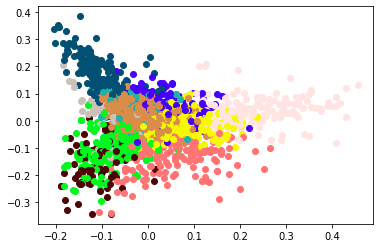

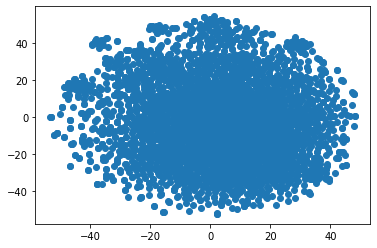

In [7]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(tfidf)
#print(labels)

X = tfidf.todense()

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
#print(reduced_data)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    #print(instance, index, labels[index])
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()